In [1]:
import torch
import torch.nn as nn
import torch.nn.init as nn_init
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from Dataloader import data_loader
import torchvision.transforms as transforms
from SegNet import SegNet

In [2]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [3]:
def output_show(train_ori, train_lbl, output, mode):
    import matplotlib.pyplot as plt
    #img = train_ori.cpu().squeeze(0).permute(1,2,0).numpy()
    img = train_ori
    
    plt.figure(figsize = (16.2, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(mode + '_ori')
    
    img = train_lbl.cpu().squeeze(0).numpy()
    
    plt.subplot(1, 3, 2)
    plt.imshow(img)
    plt.title(mode + '_lbl')
    
    img = torch.argmax(output.cpu(), dim = 0)
    img = img.squeeze(0).numpy()
    
    plt.subplot(1, 3, 3)
    plt.title('output')
    plt.imshow(img)
    plt.show()

In [4]:
# Hyprt Parameter
num_image = 2975  # Size of dataset
index = np.arange(num_image).tolist()
np.random.shuffle(index) # Shuffle data


root = '/datasets/home/14/214/c6du/data/Cityscape_modified/' # Root path
mode1 = 'train' # train, test, valid
mode2 = 'valid'
output_size = (450, 900)  # (height, width)
batch_size = 2

Transform_data = transforms.Compose([transforms.Resize(output_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ])
Transform_lbl  = transforms.Compose([transforms.Resize(output_size),
                                    ])

### First epoch / read file checkpoint_with_epoch_00000_Adam.pth.tar

load_file = False
load_file_optim = 'RMSprop'
load_file_epoch = 4
load_file_name = 'checkpoint_with_epoch_{0:05d}_fixedweight'.format(load_file_epoch) +\
        '_' + load_file_optim + '.pth.tar'


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:',device)


class_num = np.arange(-1, 34)
class_out_num = 8

net = SegNet(class_num = class_out_num, img_size = output_size)
net = net.to(device)

lrinit = 0.0001

optim_model = 'RMSprop' # 'SGD', 'Adagrad', 'RMSprop' 
momentum = 0.9
lr_change = True

if optim_model == 'Adam':
    optimizer = torch.optim.Adam(net.parameters(), lr = lrinit)
    model_type = optim_model + '_lrinit=' + str(lrinit).split('.')[-1] + \
    '_lrchange=' + str(lr_change)
    print('optimizer:', model_type)
    
elif optim_model == 'RMSprop':
    optimizer = torch.optim.RMSprop(net.parameters(),
                                    lr = lrinit,
                                    momentum = momentum)
    model_type = optim_model + '_lrinit=' + str(lrinit).split('.')[-1] + \
    '_lrchange=' + str(lr_change)
    print('optimizer:', model_type)
    
else:
    raise Exception('Optimizer not supported!')
    
criteria = nn.CrossEntropyLoss()

device: cuda:0
optimizer: RMSprop_lrinit=0001_lrchange=True


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

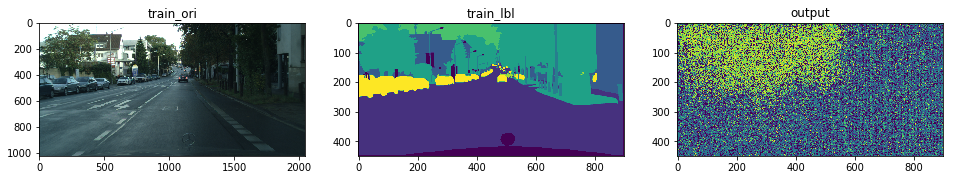

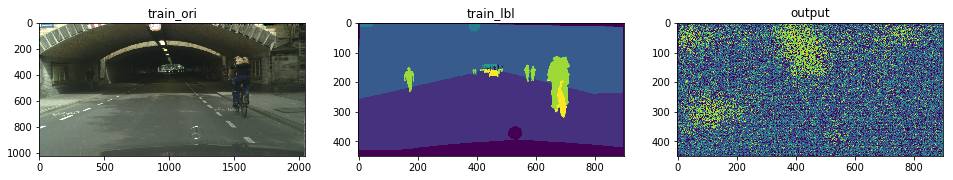

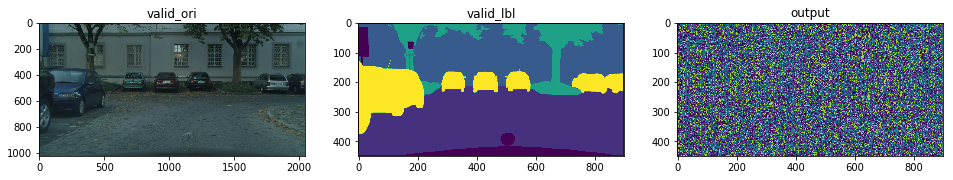

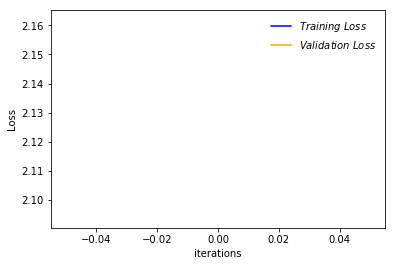

KeyboardInterrupt: 

In [5]:
from tqdm import tqdm_notebook as tqdm
import os



loss_list = []
loss_valid = []
epoch_m = 10
learn_r = lrinit

index_valid = [22, 20]
#np.random.shuffle(index_valid)
valid_loader = data_loader(index_valid, root, mode2, Transform_data, Transform_lbl, class_num, batch_size)
elements_valid = next(valid_loader)
valid_img = elements_valid[0].to(device)
valid_lbl = elements_valid[1].to(device)
valid_ori = elements_valid[2]
#valid_lst = elements_valid[3].to(device)


if not load_file:
    for epoch in tqdm(range(epoch_m)):

        np.random.shuffle(index) # Shuffle data
        train_loader = data_loader(index, root, mode1, Transform_data, Transform_lbl, class_num, batch_size)

        for counter, elements in tqdm(enumerate(train_loader)):
            train_img = elements[0].to(device)
            train_lbl = elements[1].to(device)
            train_ori = elements[2]
            
            train_weight = [[0.8618417 ],
                             [0.22257539],
                             [0.39549752],
                             [4.05901725],
                             [0.57377441],
                             [2.38839489],
                             [7.0048915 ],
                             [1.19090986]]
            
            train_weight = torch.FloatTensor(train_weight).to(device)
            # print('train_weight', train_weight)
            
            criteria = nn.CrossEntropyLoss(weight=train_weight)
            
            
            output = net(train_img)
            loss = criteria(output, train_lbl)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if counter % 100 == 0:
                loss_list.append(loss.item())
                out_valid = net(valid_img)
                loss_v = criteria(out_valid, valid_lbl)
                loss_valid.append(loss_v.item())
                
                for batch in range(batch_size):
                    output_show(train_ori[batch], train_lbl[batch, :, :],
                                output[batch, :, :, :], mode1)
                output_show(valid_ori[0],valid_lbl[0, :, :],
                            out_valid[0, :, :, :], mode2)
                plt.figure(figsize = (6, 4))
                plt.plot(loss_list, color = 'blue', label = r'$Training \ Loss$')
                plt.plot(loss_valid, color = 'orange', label = r'$Validation \ Loss$')
                plt.legend(loc='upper right',frameon=False)
                plt.xlabel('iterations')
                plt.ylabel('Loss')
                plt.show()

        if lr_change == True:

            if optim_model == 'Adam':
                
                learn_r = lrinit / 2 ** epoch
                print('lr = ' + str(learn_r))
                optimizer = torch.optim.Adam(net.parameters(), lr = learn_r)
                
            if optim_model == 'RMSprop':
                
                learn_r = lrinit / 2 ** epoch
                print('lr = ' + str(learn_r))
                optimizer = torch.optim.RMSprop(net.parameters(),
                                    lr = learn_r,
                                    momentum = momentum)

        save_file_name = 'checkpoint_with_epoch_{0:05d}_fixedweight'.format(epoch) +\
        '_' + optim_model + '.pth.tar'
        print(save_file_name)
        save_checkpoint({'epoch': epoch,
                         'net_dict': net.state_dict(),
                         'lrinit': lrinit,
                         'learn_r': learn_r,
                         'optim_model': optim_model,
                         'loss_list': loss_list,
                         'loss_valid': loss_valid,},
                        filename = './' + save_file_name) 

else:
    
    checkpoint = torch.load(load_file_name)
    epoch_s = checkpoint['epoch'] + 1
    net.load_state_dict(checkpoint['net_dict'])
    lrinit = checkpoint['lrinit']
    lrinit *= 2 ** (epoch_s - 1)
    learn_r = checkpoint['learn_r']
    optim_model = checkpoint['optim_model']
    loss_list = checkpoint['loss_list']
    loss_valid = checkpoint['loss_valid']
    
    for epoch in tqdm(range(epoch_s, epoch_s + epoch_m)):

        np.random.shuffle(index) # Shuffle data
        train_loader = data_loader(index, root, mode1, Transform_data, Transform_lbl, class_num, batch_size)

        for counter, elements in tqdm(enumerate(train_loader)):
            train_img = elements[0].to(device)
            train_lbl = elements[1].to(device)
            train_ori = elements[2]
            output = net(train_img)
            loss = criteria(output, train_lbl)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if counter % 100 == 0:
                loss_list.append(loss.item())
                out_valid = net(valid_img)
                loss_v = criteria(out_valid, valid_lbl)
                loss_valid.append(loss_v.item())
                
                for batch in range(batch_size):
                    output_show(train_ori[batch], train_lbl[batch, :, :],
                                output[batch, :, :, :], mode1)
                output_show(valid_ori[0],valid_lbl[0, :, :],
                            out_valid[0, :, :, :], mode2)
                plt.figure(figsize = (6, 4))
                plt.plot(loss_list, color = 'blue', label = r'$Training \ Loss$')
                plt.plot(loss_valid, color = 'orange', label = r'$Validation \ Loss$')
                plt.legend(loc='upper right',frameon=False)
                plt.xlabel('iterations')
                plt.ylabel('Loss')
                plt.show()

        if lr_change == True:

            if optim_model == 'Adam':
                T = 10
                learn_r = lrinit/(1+epoch/T)
                # learn_r = lrinit / 2 ** epoch
                print('lr = ' + str(learn_r))
                optimizer = torch.optim.Adam(net.parameters(), lr = learn_r)
                
            if optim_model == 'RMSprop':
                
                learn_r = lrinit / 2 ** epoch
                print('lr = ' + str(learn_r))
                optimizer = torch.optim.RMSprop(net.parameters(),
                                    lr = learn_r,
                                    momentum = momentum)
                
        save_file_name = 'checkpoint_with_epoch_{0:05d}_fixedweight'.format(epoch) +\
        '_' + optim_model + '.pth.tar'
        print(save_file_name)
        save_checkpoint({'epoch': epoch,
                         'net_dict': net.state_dict(),
                         'lrinit': lrinit,
                         'learn_r': learn_r,
                         'optim_model': optim_model,
                         'loss_list': loss_list,
                         'loss_valid': loss_valid,},
                        filename = './' + save_file_name)